In [1]:
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

In [2]:
from scipy.stats import gamma

In [3]:
alpha = 1.0
beta = 0.5

k = 7.5
theta = 1.0

In [4]:
x = np.arange(0.1, 20.0, 0.1)
y = gamma.pdf(x, a=k, scale=theta)

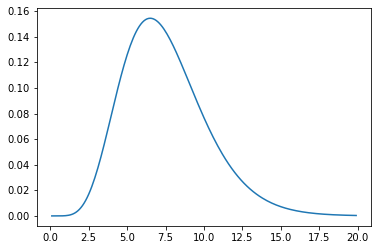

In [5]:
plt.plot(x,y)

In [6]:
bla = 1/np.finfo(np.float64).max
bla

5.562684646268003e-309

In [7]:
gamma.cdf(x, a=bla, scale=theta)

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

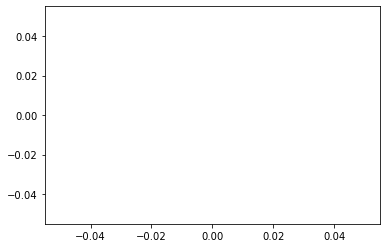

In [8]:
plt.plot(x, gamma.cdf(x, a=0.0, scale=theta))

In [9]:
shape_min = 1/np.sqrt(np.finfo(np.float64).max)
shape_max = 200

scale_min = 1/np.sqrt(np.finfo(np.float64).max)
scale_max = 200

x_min = 1/np.sqrt(np.finfo(np.float64).max)
x_max = 200

print(shape_min, shape_max)
print(scale_min, scale_max)
print(x_min, x_max)

7.458340731200208e-155 200
7.458340731200208e-155 200
7.458340731200208e-155 200


In [10]:
gamma_data = pd.DataFrame({"shape": [], "scale": [], "x": [], "y": []})
gamma_data

,shape,scale,x,y


In [17]:
DATA_POINT_NUMBER = 1e6

In [18]:
%%time
while gamma_data.shape[0] < DATA_POINT_NUMBER:
    new_shape = np.random.uniform(low=shape_min, high=shape_max/2.0)
    new_scale = np.random.uniform(low=shape_min, high=shape_max/2.0)
    new_x = np.random.uniform(low=shape_min, high=shape_max/2.0)
    
    new_y = gamma.cdf(x=new_x, a=new_shape, scale=new_scale)
    
    row_number = gamma_data.shape[0]
    gamma_data.loc[row_number, 'shape'] = new_shape
    gamma_data.loc[row_number, 'scale'] = new_scale
    gamma_data.loc[row_number, 'x'] = new_x
    gamma_data.loc[row_number, 'y'] = new_y
    
    print(round(100*gamma_data.shape[0]/DATA_POINT_NUMBER,2), end="\r")

CPU times: user 6h 32min 26s, sys: 2h 21min 31s, total: 8h 53min 57s
Wall time: 8h 49min 57s


In [19]:
x_pytorch = torch.tensor(gamma_data.iloc[:, :-1].values, dtype=torch.float32)
x_pytorch.shape

torch.Size([1000000, 3])

In [20]:
y_pytorch = torch.tensor(gamma_data.iloc[:, -1].values, dtype=torch.float32).view(gamma_data.shape[0], -1)
y_pytorch.shape

torch.Size([1000000, 1])

In [ ]:
net = torch.nn.Sequential(
        torch.nn.Linear(3, 1600),
        torch.nn.Tanh(),
        torch.nn.Linear(1600, 1600),
        torch.nn.Tanh(),
        torch.nn.Linear(1600, 800),
        torch.nn.Tanh(),
        torch.nn.Linear(800, 800),
        torch.nn.Tanh(),
        torch.nn.Linear(800, 400),
        torch.nn.Tanh(),
        torch.nn.Linear(400, 1),
        torch.nn.Sigmoid()
    )

optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
loss_func = torch.nn.MSELoss()  # this is for regression mean absolute error

BATCH_SIZE = 64
EPOCH = 200

torch_dataset = Data.TensorDataset(x_pytorch, y_pytorch)

loader = Data.DataLoader(
    dataset=torch_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True, num_workers=2,)

losses_list = []
# start training
for epoch in range(EPOCH):
    
    epoch_loss_list = []
    for step, (batch_x, batch_y) in enumerate(loader): # for each training step
        
        
        prediction = net(batch_x)     # input x and predict based on x

        loss = loss_func(prediction, batch_y)     # must be (1. nn output, 2. target)
        if ((step % 100) == 0):
            print(step, epoch, round(np.mean(epoch_loss_list), 5), end="\r")
        
        epoch_loss_list.append(np.sqrt(loss.item()))

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
        
    losses_list.append(np.mean(epoch_loss_list))


In [ ]:
plt.plot(losses_list);
plt.yscale('log')